In [8]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import transforms as T
import torchvision.transforms.functional as F

# Визуализация аугментаций  
Для лучшего понимания какие изображения используется во время обучения можно визуализировать разные аугментации на одном изображении

## Выбор базового изображения

In [9]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class with lable 1
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


plt.rcParams["savefig.bbox"] = "tight"


def show(img, out_path=None):
    fig, axs = plt.subplots(ncols=1, squeeze=False)
    img = img.detach()
    img = F.to_pil_image(img)
    axs[0, 0].imshow(np.asarray(img))
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if out_path is not None:
        fig.savefig(out_path)
        plt.close(fig)
    else:
        fig.show()

In [10]:
dataset_root = "../data/PennFudanPed"
dataset = PennFudanDataset(dataset_root)

In [11]:
BASE_IMAGE_INDEX = 11
base_image = dataset[BASE_IMAGE_INDEX][0]
base_boxes = dataset[BASE_IMAGE_INDEX][1]

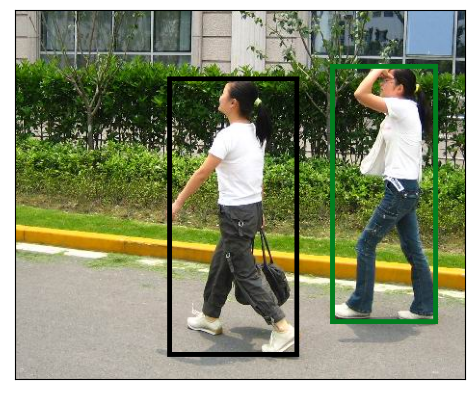

In [12]:
result = draw_bounding_boxes(
    T.PILToTensor()(base_image)[0], base_boxes["boxes"], width=5
)

show(result)

## Выбор аугментаций

In [13]:
import transforms as T

transforms = []

transforms.append(T.PILToTensor())
transforms.append(T.ConvertImageDtype(torch.float))

transforms.append(T.RandomHorizontalFlip(p=0.5))
transforms.append(T.RandomPhotometricDistort())
transforms.append(T.RandomZoomOut(side_range=(1.0, 2.0), p=0.8))
transforms.append(
    T.RandomIoUCrop(
        min_scale=0.5,
        max_scale=1.0,
        min_aspect_ratio=0.5,
        max_aspect_ratio=2.0,
    )
)

transform = T.Compose(transforms)

## Визуализация полученных случайных изображений

In [14]:
from pathlib import Path

SAMPLE_SIZE = 20

copy_past_trans = T.SimpleCopyPaste()
out_dir = Path("../../outputs/augsample")

out_dir.mkdir(exist_ok=True)

for i in range(SAMPLE_SIZE):
    base_image = dataset[BASE_IMAGE_INDEX][0]
    base_boxes = dataset[BASE_IMAGE_INDEX][1]

    transformed_image, transformed_bboxes = transform(base_image, base_boxes)
    result = draw_bounding_boxes(
        T.ConvertImageDtype(torch.uint8)(transformed_image)[0],
        transformed_bboxes["boxes"],
        width=5,
    )
    show(result, out_dir / f"{i}.png")